In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw8.ipynb")

# CPSC 330 - Applied Machine Learning

## Homework 8: Introduction to Computer vision and Time Series

**Due date: see the [Calendar](https://htmlpreview.github.io/?https://github.com/UBC-CS/cpsc330/blob/master/docs/calendar.html).**

## Imports

In [2]:
from hashlib import sha1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score
import warnings
import numpy as np
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

<!-- BEGIN QUESTION -->

<div class="alert alert-info">
    
## Instructions
rubric={points}

You will earn points for following these instructions and successfully submitting your work on Gradescope.  

### Group wotk instructions

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2.
  
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).
- If you would like to use late tokens for the homework, all group members must have the necessary late tokens available. Please note that the late tokens will be counted for all members of the group.   


### General submission instructions

- Please **read carefully
[Use of Generative AI policy](https://ubc-cs.github.io/cpsc330-2025W1/syllabus.html#use-of-generative-ai-in-the-course)** before starting the homework assignment. 
- **Run all cells before submitting:** Go to `Kernel -> Restart Kernel and Clear All Outputs`, then select `Run -> Run All Cells`. This ensures your notebook runs cleanly from start to finish without errors.
  
- **Submit your files on Gradescope.**  
   - Upload only your `.ipynb` file **with outputs displayed** and any required output files.
     
   - Do **not** submit other files from your repository.  
   - If you need help, see the [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/).  
- **Check that outputs render properly.**  
   - Make sure all plots and outputs appear in your submission.
     
   - If your `.ipynb` file is too large and doesn't render on Gradescope, also upload a PDF or HTML version so the TAs can view your work.  
- **Keep execution order clean.**  
   - Execution numbers must start at "1" and increase in order.
     
   - Notebooks without visible outputs may not be graded.  
   - Out-of-order or missing execution numbers may result in mark deductions.  
- **Follow course submission guidelines:** Review the [CPSC 330 homework instructions](https://ubc-cs.github.io/cpsc330-2025W1/docs/homework_instructions.html) for detailed guidance on completing and submitting assignments. 
   
</div>

_Points:_ 2

<!-- END QUESTION -->

<br><br>

## Exercise 1: time series prediction

In this exercise we'll be looking at a [dataset of avocado prices](https://www.kaggle.com/neuromusic/avocado-prices). You should start by downloading the dataset and storing it under the `data` folder. We will be forcasting average avocado price for the next week. 

In [3]:
df = pd.read_csv("data/avocado.csv", parse_dates=["Date"], index_col=0)
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [4]:
df.shape

(18249, 13)

In [5]:
df["Date"].min()

Timestamp('2015-01-04 00:00:00')

In [6]:
df["Date"].max()

Timestamp('2018-03-25 00:00:00')

It looks like the data ranges from the start of 2015 to March 2018 (~2 years ago), for a total of 3.25 years or so. Let's split the data so that we have a 6 months of test data.

In [7]:
split_date = '20170925'
df_train = df[df["Date"] <= split_date]
df_test  = df[df["Date"] >  split_date]

In [8]:
assert len(df_train) + len(df_test) == len(df)

<br><br>

<!-- BEGIN QUESTION -->

### 1.1 How many time series? 
rubric={points:4}

In the [Rain in Australia](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package) dataset from lecture demo, we had different measurements for each Location. 

We want you to consider this for the avocado prices dataset. For which categorical feature(s), if any, do we have separate measurements? Justify your answer by referencing the dataset.

<div class="alert alert-warning">

Solution_1.1
    
</div>

_Points:_ 4

In this dataset, we have separate measurements for both region and type. 

Region: This tells us the region that the avocado is being sold from. 
Type: This tells us the type of avocado being sold (conventional or organic).

We can see that even for examples with the same date and region, the measurements for conventional/organic avocados are tracked separately as they're effectively two different products. As such, they can have different prices, volumes, and trends as a function of time. 

Grouping by both region and type below, we can see that there are 54 unique regions and 2 unique types, giving 108 unique combinations of region/type. Each of these combinations have their own set of weekly measurements, so they can each be thought of as their own time series.

In [9]:
print("Number of unique regions in dataset:", df["region"].nunique())
print("Regions:", df["region"].unique())

Number of unique regions in dataset: 54
Regions: ['Albany' 'Atlanta' 'BaltimoreWashington' 'Boise' 'Boston'
 'BuffaloRochester' 'California' 'Charlotte' 'Chicago' 'CincinnatiDayton'
 'Columbus' 'DallasFtWorth' 'Denver' 'Detroit' 'GrandRapids' 'GreatLakes'
 'HarrisburgScranton' 'HartfordSpringfield' 'Houston' 'Indianapolis'
 'Jacksonville' 'LasVegas' 'LosAngeles' 'Louisville' 'MiamiFtLauderdale'
 'Midsouth' 'Nashville' 'NewOrleansMobile' 'NewYork' 'Northeast'
 'NorthernNewEngland' 'Orlando' 'Philadelphia' 'PhoenixTucson'
 'Pittsburgh' 'Plains' 'Portland' 'RaleighGreensboro' 'RichmondNorfolk'
 'Roanoke' 'Sacramento' 'SanDiego' 'SanFrancisco' 'Seattle'
 'SouthCarolina' 'SouthCentral' 'Southeast' 'Spokane' 'StLouis' 'Syracuse'
 'Tampa' 'TotalUS' 'West' 'WestTexNewMexico']


In [10]:
print("Number of unique types in dataset:", df["type"].nunique())
print("Types:", df["type"].unique())

Number of unique types in dataset: 2
Types: ['conventional' 'organic']


In [11]:
df.groupby(["region", "type"]).size()

region               type        
Albany               conventional    169
                     organic         169
Atlanta              conventional    169
                     organic         169
BaltimoreWashington  conventional    169
                                    ... 
TotalUS              organic         169
West                 conventional    169
                     organic         169
WestTexNewMexico     conventional    169
                     organic         166
Length: 108, dtype: int64

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.2 Equally spaced measurements? 
rubric={points:4}

In the Rain in Australia dataset, the measurements were generally equally spaced but with some exceptions. How about with this dataset? Justify your answer by referencing the dataset.

<div class="alert alert-warning">

Solution_1.2
    
</div>

_Points:_ 4

In the Rain in Australia dataset, most measurements were daily, but there were irregularities due to missing dates or skipped entries. In contrast, the avocado prices dataset is much more regularly spaced, but it still contains some missing values.

When examining the time gaps between dates for each region-type combination, the time-spacing distribution shows:
7 days     18139
14 days        1
21 days        1

This tells us that most observations are exactly 7 days apart, indicating that the dataset is intended to represent weekly measurements. It also tells us that there is a single instance where there is a 14 day gap (perhaps 1 missing value), and an instance where there is a 21 day gap (perhaps 2 sequential missing values).

We can conclude that our dataset has regularly spaced time points, occurring on a weekly basis, with 2 exceptions, possibly because of missing values.

In [12]:
df["Date"] = pd.to_datetime(df["Date"])

all_diffs = []

for (region, type_), group in df.groupby(["region", "type"]):
    group = group.sort_values("Date")
    diffs = group["Date"].diff().dropna()
    all_diffs.extend(diffs)

In [13]:
diff_series = pd.Series(all_diffs)

In [14]:
diff_series.value_counts().sort_index()

7 days     18139
14 days        1
21 days        1
Name: count, dtype: int64

In [15]:
# Adapated from CPSC330 Lecture 19
def plot_time_spacing_distribution(df, region):
    """
    Plots a single combined distribution of time spacing for a given region,
    computed separately within each type and then merged.
    """
    df['Date'] = pd.to_datetime(df['Date'])

    # Filter to one region
    region_data = df[df['region'] == region]

    if region_data.empty:
        print(f"No data available for region: {region}")
        return

    all_diffs = []

    # Compute spacing separately for each type, then collect together
    for t in region_data['type'].unique():
        subset = region_data[region_data['type'] == t]
        diffs = subset['Date'].sort_values().diff().dropna()
        all_diffs.extend(diffs)

    # Convert to Series
    all_diffs = pd.Series(all_diffs)

    # Count distinct time intervals
    value_counts = all_diffs.value_counts().sort_index()

    print(f"Combined time spacing counts for {region}:\n{value_counts}\n")

    # Plot one single distribution
    plt.bar(value_counts.index.astype(str), value_counts.values,
            edgecolor='black')
    plt.title(f"Combined Time Difference Distribution for {region}")
    plt.xlabel("Time Difference (days)")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Combined time spacing counts for Albany:
7 days    284
Name: count, dtype: int64



/var/folders/rh/1lwm2q0170db261y_60fjp_00000gn/T/ipykernel_97607/228903653.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


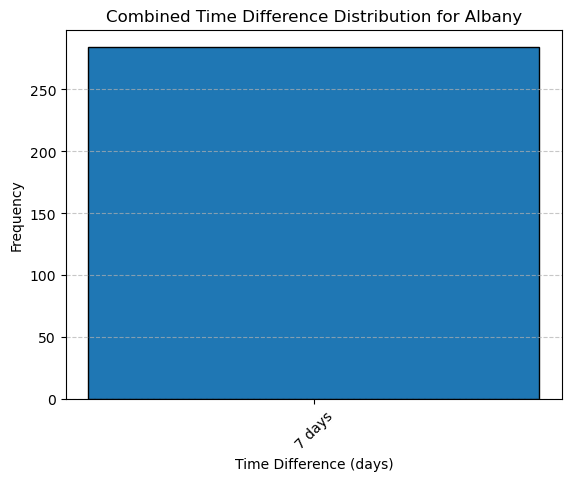

In [16]:
plot_time_spacing_distribution(df_train, "Albany")

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.3 Interpreting regions 
rubric={points:4}

In the Rain in Australia dataset, each location was a different place in Australia. For this dataset, look at the names of the regions. Do you think the regions are also all distinct, or are there overlapping regions? Justify your answer by referencing the data.

<div class="alert alert-warning">

Solution_1.3
    
</div>

_Points:_ 4

Most of the regions in the dataset are distinct cities (ie. Albany, Atlanta, etc..., but there are also some larger regions that seem to combine larger areas or geographic regions (ie. TotalUS, West, California, etc...) So not all of the regions are  completely distinct, there are some aggregated areas that include multiple cities. This is different from the Australia rain dataset, where each location was entirely distinct, and may be an important consideration for us as we progress with this problem.  

In [17]:
df["region"].unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

<!-- END QUESTION -->

<br><br>

We will use the entire dataset despite any location-based weirdness uncovered in the previous part.

We will be trying to forecast the avocado price. The function below is adapted from the lecture.

In [18]:
import pandas as pd


def create_lag_feature(
    df: pd.DataFrame,
    orig_feature: str,
    lag: int,
    groupby: list[str],
    new_feature_name: str | None = None,
    clip: bool = False,
) -> pd.DataFrame:
    """
    Create a lagged (or ahead) version of a feature, optionally per group.

    Assumes df is already sorted by time within each group and has unique indices.

    Parameters
    ----------
    df : pd.DataFrame
        The dataset.
    orig_feature : str
        Name of the column to lag.
    lag : int
        The lag:
          - negative → values from the past (t-1, t-2, ...)
          - positive → values from the future (t+1, t+2, ...)
    groupby : list of str
        Column(s) to group by if df contains multiple time series.
    new_feature_name : str, optional
        Name of the new column. If None, a name is generated automatically.
    clip : bool, default False
        If True, drop rows where the new feature is NaN.

    Returns
    -------
    pd.DataFrame
        A new dataframe with the additional column added.
    """
    if lag == 0:
        raise ValueError("lag cannot be 0 (no shift). Use the original feature instead.")

    # Default name if not provided
    if new_feature_name is None:
        if lag < 0:
            new_feature_name = f"{orig_feature}_lag{abs(lag)}"
        else:
            new_feature_name = f"{orig_feature}_ahead{lag}"

    df = df.copy()

    # Map your convention (negative=past, positive=future) to pandas shift
    # pandas: shift(+k) → past, shift(-k) → future
    periods = abs(lag) if lag < 0 else -lag

    df[new_feature_name] = (
        df.groupby(groupby, sort=False)[orig_feature]
          .shift(periods)
    )

    if clip:
        df = df.dropna(subset=[new_feature_name])

    return df


We first sort our dataframe properly:

In [19]:
df_sort = df.sort_values(by=["region", "type", "Date"]).reset_index(drop=True)
df_sort

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico
18247,2018-03-18,1.56,15896.38,2055.35,1499.55,0.00,12341.48,12114.81,226.67,0.0,organic,2018,WestTexNewMexico


We then call `create_lag_feature`. This creates a new column in the dataset `AveragePriceNextWeek`, which is the following week's `AveragePrice`. We have set `clip=True` which means it will remove rows where the target would be missing.

In [20]:
df_hastarget = create_lag_feature(df_sort, "AveragePrice", +1, ["region", "type"], "AveragePriceNextWeek", clip=True)
df_hastarget

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,2018-02-18,1.56,17597.12,1892.05,1928.36,0.00,13776.71,13553.53,223.18,0.0,organic,2018,WestTexNewMexico,1.57
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico,1.54
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico,1.56
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico,1.56


Our goal is to predict `AveragePriceNextWeek`. 

Let's split the data:

In [21]:
df_train = df_hastarget[df_hastarget["Date"] <= split_date]
df_test  = df_hastarget[df_hastarget["Date"] >  split_date]

<br><br>

<!-- BEGIN QUESTION -->

### 1.4 `AveragePrice` baseline 
rubric={points}

Soon we will want to build some models to forecast the average avocado price a week in advance. Before we start with any ML though, let's try a baseline. Previously we used `DummyClassifier` or `DummyRegressor` as a baseline. This time, we'll do something else as a baseline: we'll assume the price stays the same from this week to next week. So, we'll set our prediction of "AveragePriceNextWeek" exactly equal to "AveragePrice", assuming no change. That is kind of like saying, "If it's raining today then I'm guessing it will be raining tomorrow". This simplistic approach will not get a great score but it's a good starting point for reference. If our model does worse that this, it must not be very good. 

Using this baseline approach, what $R^2$ do you get on the train and test data?

<div class="alert alert-warning">

Solution_1.4
    
</div>

_Points:_ 4

On the training set I got an r2 score of 0.83, while on the test set I got an r2 score of 0.76.

In [22]:
train_r2 = r2_score(df_train["AveragePriceNextWeek"], df_train["AveragePrice"])

In [23]:
test_r2 = r2_score(df_test["AveragePriceNextWeek"], df_test["AveragePrice"])

In [24]:
print("Train r2:", train_r2)
print("Test r2:", test_r2)

Train r2: 0.8285800937261841
Test r2: 0.7631780188583048


In [25]:
assert not train_r2 is None, "Are you using the correct variable name?"
assert not test_r2 is None, "Are you using the correct variable name?"
assert sha1(str(round(train_r2, 3)).encode('utf8')).hexdigest() == 'b1136fe2a8918904393ab6f40bfb3f38eac5fc39', "Your training score is not correct. Are you using the right features?"
assert sha1(str(round(test_r2, 3)).encode('utf8')).hexdigest() == 'cc24d9a9b567b491a56b42f7adc582f2eefa5907', "Your test score is not correct. Are you using the right features?"

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.5 Forecasting average avocado price
rubric={points:10}

Now that the baseline is done, let's build some models to forecast the average avocado price a week later. Experiment with a few approachs for encoding the date. Justify the decisions you make. Which approach worked best? Report your test score and briefly discuss your results.

Benchmark: you should be able to achieve $R^2$ of at least 0.79 on the test set. I got to 0.80, but not beyond that. Let me know if you do better!

Note: because we only have 2 splits here, we need to be a bit wary of overfitting on the test set. Try not to test on it a ridiculous number of times. If you are interested in some proper ways of dealing with this, see for example sklearn's [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html), which is like cross-validation for time series data.

<div class="alert alert-warning">

Solution_1.5
    
</div>

_Points:_ 10

I experimented with several approaches of encoding the date. First I extracted standard features such as month, week, and dayofweek, however I wasn't getting strong test scores with my linear ridge model (~0.7) at first. To fix this, I then applied cyclical encoding using sine and cosine transformations to capture the periodic nature of these features. This allowed the model to understand that, for example, December 12th is close to January 1st, which standard integer encoding would not capture. 


I included these cyclical date features along with other numerical variables (e.g., past prices, total volume, bag counts) and categorical variables (type and region) in a Ridge regression model. Using TimeSeriesSplit for cross-validation, I optimized the regularization hyperparameter alpha. The results showed that alpha = 250 achieved the highest CV r2 of 0.8277. When fitting the final model, the train r2 was 0.845 and the test r2 was 0.807, which suggests strong generalizeability.

Overall, cyclical encoding of date features proved effective because it preserves the inherent periodicity in the data, which improved the predictive performance over using simple integer encodings for month, week, or day of the week. 

In [26]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LogisticRegression

In [27]:
df_train = df_train.copy()
df_test  = df_test.copy()

# Extract date features
for df_ in [df_train, df_test]:
    # Encode date features
    df_.loc[:, "month"] = df_["Date"].dt.month
    df_.loc[:, "week"] = df_["Date"].dt.isocalendar().week.astype(int)
    df_.loc[:, "dayofweek"] = df_["Date"].dt.dayofweek

    # Cyclical encoding
    df_.loc[:, "month_sin"] = np.sin(2 * np.pi * df_["month"]/12)
    df_.loc[:, "month_cos"] = np.cos(2 * np.pi * df_["month"]/12)
    df_.loc[:, "week_sin"]  = np.sin(2 * np.pi * df_["week"]/52)
    df_.loc[:, "week_cos"]  = np.cos(2 * np.pi * df_["week"]/52)
    df_.loc[:, "dow_sin"]   = np.sin(2 * np.pi * df_["dayofweek"]/7)
    df_.loc[:, "dow_cos"]   = np.cos(2 * np.pi * df_["dayofweek"]/7)


In [28]:
numerical_feats = ["AveragePrice", "Total Volume", "4046", "4225", "4770",
                   "Total Bags", "Small Bags", "Large Bags", "XLarge Bags",
                   "month_sin", "month_cos", "week_sin", "week_cos", "dow_sin", "dow_cos"]

categorical_feats = ["type", "region"]

X_train = df_train.drop(["AveragePriceNextWeek", "Date"], axis = 1)
y_train = df_train["AveragePriceNextWeek"]

X_test = df_test.drop(["AveragePriceNextWeek", "Date"], axis = 1)
y_test = df_test["AveragePriceNextWeek"]

preprocessor = make_column_transformer(
    (StandardScaler(), numerical_feats),
    (OneHotEncoder(handle_unknown = "ignore", drop = "if_binary"), categorical_feats)
)

In [29]:
alphas = [0.1, 1, 10, 50, 100, 250, 500]
best_alpha = None
best_score = -np.inf

for alpha in alphas:
    ridge_pipe = make_pipeline(preprocessor, Ridge(alpha = alpha, max_iter = 1000))
    scores = cross_val_score(ridge_pipe, X_train, y_train, cv = TimeSeriesSplit(), scoring = "r2")
    mean_score = scores.mean()
    print(f"Alpha: {alpha}, CV r2: {mean_score:.4f}")
    if mean_score > best_score:
        best_score = mean_score
        best_alpha = alpha

Alpha: 0.1, CV r2: 0.8161
Alpha: 1, CV r2: 0.8159
Alpha: 10, CV r2: 0.8175
Alpha: 50, CV r2: 0.8238
Alpha: 100, CV r2: 0.8271
Alpha: 250, CV r2: 0.8277
Alpha: 500, CV r2: 0.8195


In [30]:
ridge_pipe = make_pipeline(preprocessor, Ridge(alpha=best_alpha, max_iter=1000))
ridge_pipe.fit(X_train, y_train)

train_r2 = ridge_pipe.score(X_train, y_train)
test_r2 = ridge_pipe.score(X_test, y_test)

print(f"Best alpha: {best_alpha}")
print("Train r2:", train_r2)
print("Test r2:", test_r2)

Best alpha: 250
Train r2: 0.8451755405015134
Test r2: 0.8068419486978334


<!-- END QUESTION -->

<br><br><br><br>

## Exercise 2: Short answer questions

<!-- BEGIN QUESTION -->

### 2.1 Time series

rubric={points:6}

The following questions pertain to Lecture 20 on time series data:

1. Sometimes a time series has missing time points or, worse, time points that are unequally spaced in general. Give an example of a real world situation where the time series data would have unequally spaced time points.
2. In class we discussed two approaches to using temporal information: encoding the date as one or more features, and creating lagged versions of features. Which of these (one/other/both/neither) two approaches would struggle with unequally spaced time points? Briefly justify your answer.
3. When studying time series modeling, we explored several ways to encode date information as a feature for the citibike dataset. When we used time of day as a numeric feature, the Ridge model was not able to capture the periodic pattern. Why? How did we tackle this problem? Briefly explain.

<div class="alert alert-warning">

Solution_2.1
    
</div>

_Points:_ 6

1. A real-world example of an irregular time series might occur within a hospital/clinic setting. Patients don't always show up on a regular, equally intervaled time schedule for things like lab test results, and it is possible that a patient might miss an appointment. And so we would expect to see a dataset encoding the appointments for patients to have irregular time points as well as some missing values.

2. Lag features would have a more difficult time with unequally spaced time points, as they assume a consistent interval between observations, and when the spacing is irregular, a lag of one time step no longer represents a consistent temporal difference, which can lead to distortion of the modeled relationship. Contrarily, the date as features approach remains somewhat feasible since each observastion carries its own timestamp, independent of the spacing between time points.

3. Time of day is circular, and so linear models like Ridge (which are intended to capture linear relationships) fail to recognize the cyclical nature of this sort of time encoding. This problem was addressed by converting time of day into sine and cosine values, so that the model could learn the periodic pattern more robustly.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 2.2 Computer vision 
rubric={points:6}

The following questions pertain to the lecture on multiclass classification and introduction to computer vision. 

1. How many parameters (coefficients and intercepts) will `sklearn`’s `LogisticRegression()` model learn for a four-class classification problem, assuming that you have 10 features? Briefly explain your answer.
2. In Lecture 19, we briefly discussed how neural networks are sort of like `sklearn`'s pipelines, in the sense that they involve multiple sequential transformations of the data, finally resulting in the prediction. Why was this property useful when it came to transfer learning?
3. Imagine that you have a small dataset with ~1000 images containing pictures and names of 50 different Computer Science faculty members from UBC. Your goal is to develop a reasonably accurate multi-class classification model for this task. Describe which model/technique you would use and briefly justify your choice in one to three sentences.

<div class="alert alert-warning">

Solution_2.2
    
</div>

_Points:_ 6

1. For a 4-class classification problem with 10 features, LogisticRegression will learn a total of 44 parameters. This is because in multiclass logistic regression, the model fits a separate set of coefficients for each class, and so since each class has 10 feature coefficients plus 1 intercept/bias term, we'll have 4 x (10 + 1) = 44 parameters in total.

2. This property is useful for transfer learning as it allows pre-trained layers to serve as general feature extractors. And so by reusing these layers on new but related tasks, we can use their learned representations (with some adjustments for our specific case) without retraining an entire network, making our learning much more efficient.

3. I would use a pre-trained convolution neural network (CNN) model with transfer learning. Since we only have ~1000 images to work with, we don't have a lot of images to train from scratch, and so this approach would allow use to use a pre-trained network that already captures a lot of the visual features, reducing the amount of data needed to achieve a reasonably accurate classification.

<!-- END QUESTION -->

<br><br>

Before submitting your assignment, please make sure you have followed all the instructions in the Submission Instructions section at the top. 

Here is a quick checklist before submitting: 

- [ ] Restart kernel, clear outputs, and run all cells from top to bottom.  
- [ ] `.ipynb` file runs without errors and contains all outputs.  
- [ ] Only `.ipynb` and required output files are uploaded (no extra files).  
- [ ] Execution numbers start at **1** and are in order.  
- [ ] If `.ipynb` is too large and doesn't render on Gradescope, also upload a PDF/HTML version.  
- [ ] Reviewed the [CPSC 330 homework instructions](https://ubc-cs.github.io/cpsc330-2025W1/docs/homework_instructions.html).  

![](img/eva-well-done.png)